In [1]:
#Importing all needed librarys
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pipetorch.train import *
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from tqdm import tqdm
from torch import nn, optim
import seaborn as sns
import torch.nn.functional as F

# importing the libraries
import pandas as pd
import numpy as np

# for creating validation set
from sklearn.model_selection import train_test_split


import torchvision
from torchvision.datasets import ImageFolder

using gpu 2


In [2]:
#Checking wich GPU is beeing used

!nvidia-smi

Mon Nov 29 15:32:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 29%   27C    P8    17W / 250W |   3892MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 29%   

In [3]:
#Load data
data_speaker1_dir = 'dialogue/Dataset/SameVoiceDetection/2d_dataset/speaker1.npy'
#data_speaker1_dir = 'dialogue/Leander/outputs/speaker1.npy'
data_speaker2_dir = 'dialogue/Dataset/SameVoiceDetection/2d_dataset/speaker2.npy'
#data_speaker2_dir = 'dialogue/Leander/outputs/speaker2.npy'
labels_dir = 'dialogue/Dataset/SameVoiceDetection/2d_dataset/labels.npy'
#labels_dir = 'dialogue/Leander/outputs/labels.npy'

data_speaker1 = np.load(data_speaker1_dir, allow_pickle = True)
data_speaker2 = np.load(data_speaker2_dir, allow_pickle = True)
data_speaker1 = data_speaker1.reshape((len(data_speaker1),40,len(data_speaker1[0])//40))
data_speaker2 = data_speaker2.reshape((len(data_speaker2),40,len(data_speaker2[0])//40))
labels = np.load(labels_dir, allow_pickle = True)

print(data_speaker1.shape, data_speaker2.shape)
print(labels)

(15200, 40, 16) (15200, 40, 16)
[[1.]
 [0.]
 [1.]
 ...
 [0.]
 [1.]
 [0.]]


In [4]:
#df_data.drop(['isSpeaking'],axis = 1)
X1_train, X1_test, y_train, y_test = train_test_split(data_speaker1, labels, test_size = 0.2, random_state = 23)
X1_train, X1_val, y_train, y_val = train_test_split(X1_train, y_train, test_size = 0.2, random_state = 23)

X2_train, X2_test, y_train, y_test = train_test_split(data_speaker2, labels, test_size = 0.2, random_state = 23)
X2_train, X2_val, y_train, y_val = train_test_split(X2_train, y_train, test_size = 0.2, random_state = 23)

print(type(X1_train))
#print(X_train)

<class 'numpy.ndarray'>


In [5]:
#print(pd.DataFrame(X_train))
X1_train = torch.from_numpy(X1_train).float()
#X1_train = X1_train.unsqueeze_(-1)
#X1_train = X1_train.transpose(1, 2)

X2_train = torch.from_numpy(X2_train).float()
#X2_train = X2_train.unsqueeze_(-1)
#X2_train = X2_train.transpose(1, 2)

y_train = torch.from_numpy(y_train).float()

X1_test = torch.from_numpy(X1_test).float()
#X1_test = X1_test.unsqueeze_(-1)
#X1_test = X1_test.transpose(1, 2) #torch.tensor(X_test.values)

X2_test = torch.from_numpy(X2_test).float()
#X2_test = X2_test.unsqueeze_(-1)
#X2_test = X2_test.transpose(1, 2)

y_test = torch.from_numpy(y_test).float()

X1_val = torch.from_numpy(X1_val).float()
#X1_val = X1_val.unsqueeze_(-1)
#X1_val = X1_val.transpose(1, 2)

X2_val = torch.from_numpy(X2_val).float()
#X2_val = X2_val.unsqueeze_(-1)
#X2_val = X2_val.transpose(1, 2)

y_val = torch.from_numpy(y_val).float()
#print(X_val.shape, X_val)
print(X2_train.shape, y_train.shape)
#print(test_X.shape)
print(X2_train[0])


torch.Size([9728, 40, 16]) torch.Size([9728, 1])
tensor([[-6.1127e+02, -6.1127e+02, -6.1127e+02, -6.1127e+02, -6.1125e+02,
         -4.2397e+02, -2.8594e+02, -1.9819e+02, -2.0949e+02, -2.5603e+02,
         -2.4439e+02, -2.0921e+02, -1.6878e+02, -1.7959e+02, -2.4333e+02,
         -2.6935e+02],
        [ 0.0000e+00,  4.6558e-04,  0.0000e+00,  0.0000e+00,  5.0177e-03,
         -1.0616e+01,  2.4356e+01,  9.9508e+01,  1.5043e+02,  1.6638e+02,
          1.6236e+02,  1.5187e+02,  1.5148e+02,  1.4887e+02,  1.0869e+02,
          9.3501e+01],
        [ 0.0000e+00, -2.0551e-03,  0.0000e+00,  0.0000e+00, -2.2149e-02,
          2.0407e+01,  3.8085e+01,  5.8528e+01,  6.8018e+01,  8.7144e+01,
          5.8028e+01,  4.4785e+01,  4.2479e+01,  4.2549e+01,  4.7621e+01,
          5.6290e+01],
        [ 0.0000e+00, -1.3169e-03,  0.0000e+00,  0.0000e+00, -1.4192e-02,
         -3.8298e+00,  2.9616e+00,  5.0282e+00,  7.6712e-01, -1.7323e+01,
         -9.1165e+00, -7.3274e+00, -1.0356e+01, -1.0879e+01,  3.2876

In [6]:
class model(nn.Module):
    def __init__(self,n_features,kernel_size):
        super(model, self).__init__()
        self.conv1 = nn.Conv1d(n_features, 40, kernel_size=3, stride = 1) #1 input channels, 100 output channels
        self.conv2 = nn.Conv1d(40, 80, kernel_size=3, stride = 1) #100 input channels from previous Conv. layer, 75 out
        self.conv3 = nn.Conv1d(200, 350, kernel_size=3, stride = 1) #75 input channels from previous Conv. layer, 50 out
        self.conv4 = nn.Conv1d(160, 80, kernel_size=3, stride = 1) #75 input channels from previous Conv. layer, 50 out
        self.conv5 = nn.Conv1d(80, 60, kernel_size=3, stride = 1) #75 input channels from previous Conv. layer, 50 out
        self.conv5_drop = nn.Dropout2d() #dropout
        
        self.fc1 = nn.Linear(320, 100) #Fully-connected classifier layer 
        self.fc2 = nn.Linear(100, 1) #Fully-connected classifier layer
        self.fc3 = nn.Linear(350, 150) #Fully-connected classifier layer
        self.fc4 = nn.Linear(150, 1) #Fully-connected classifier layer
        # self.fc5 = nn.Linear(20,1) #Fully-connected classifier layer
    
    def forward_one_voice(self, x):
        #print(x.shape)
        x = F.relu(F.max_pool1d(self.conv1(x), 2))
        #print(x.shape)
        x = F.relu(F.max_pool1d(self.conv2(x), 2))
        #x = F.relu(F.max_pool1d(self.conv3(x), 2))
        # x = F.relu(F.max_pool1d(self.conv4(x), 2))
        # x = F.relu(F.max_pool1d(self.conv5_drop(self.conv5(x)), 2))
        
        #point A
        x = x.reshape(len(x), -1)
        #print(x.shape)
        batch_size = len(x)
        #print(batch_size)
        #x = self.fc1(x)
        #x = self.fc2(x)
        # x = self.fc3(x)
        # x = self.fc4(x)
        # x = self.fc5(x)
        
        return x
    
    def forward(self, x1, x2):
        x1 = self.forward_one_voice(x1)
        x2 = self.forward_one_voice(x2)
        x = torch.concat([x1, x2], axis = 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        #x = self.fc3(x)
        #x = self.fc4(x)
        #print(x1)
        # #print(x1.data.cpu().numpy()[0])
        #x1 = torch.diff(x1, dim=0)
        #print(x1)
        
        # #x = np.concatenate([x1.detach().cpu(), x2.detach().cpu()], axis=1)
        # #print(x)
        # #print(x1.shape)
        # #x = torch.from_numpy(x).float()

        
        # #point B
        #x = self.forward_that_is_not_going_to_work(x1, x2)
        return torch.sigmoid(x)
    
    def post_forward(self, y): 
        return torch.round(y)
    
CNN = model(X1_train.shape[1],kernel_size = 3)

In [7]:
weight = torch.FloatTensor([1])
criterion = nn.BCELoss()
optimizer = optim.Adam(CNN.parameters(), lr=0.00003)

In [8]:
train_ds = TensorDataset(X1_train, X2_train, y_train)
test_ds = TensorDataset(X1_test, X2_test, y_test)

In [9]:
train_dl = DataLoader(train_ds, batch_size=64, num_workers = 4, pin_memory = True)
#test_dl = DataLoader(test_ds, batch_size= 32)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# X1_train = X1_train.to(device)
# X2_train = X2_train.to(device)
# y_train = y_train.to(device)
X1_test = X1_test.to(device)
X2_test = X2_test.to(device)
y_test = y_test.to(device)
X1_val = X1_val.to(device)
X2_val = X2_val.to(device)
y_val = y_val.to(device)
CNN = CNN.to(device)
criterion = criterion.to(device)
print(device)

cuda


In [11]:
def calculate_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum().float() / len(y_true)

In [12]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

Results = pd.DataFrame(columns = ['Epoch', 'Acc_train', 'Acc_test', 'test_loss', 'train_loss'])
    
for epoch in range(200):
        for x1, x2, y in train_dl:
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = CNN(x1, x2)
            #print(y_pred.shape)
            #y_pred = torch.squeeze(y_pred)
            #y_pred = y_pred.unsqueeze_(-1)
            #print(y_pred.shape, y_train.shape)
            #print(y_pred.shape)
            train_loss = criterion(y_pred, y)
            train_loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
        
            train_acc = calculate_accuracy(y, CNN.post_forward(y_pred))
        
            y_test_pred = CNN(X1_test, X2_test)

            #y_test_pred = torch.squeeze(y_test_pred)
            
            #y_test_pred = y_test_pred.unsqueeze_(-1)

            test_loss = criterion(y_test_pred, y_test)
        
            test_acc = calculate_accuracy(y_test, CNN.post_forward(y_test_pred))
        
            result = {'Epoch': epoch, 'Acc_train': round_tensor(train_acc), 'Acc_test': round_tensor(test_acc), 'test_loss': round_tensor(test_loss), 'train_loss': round_tensor(train_loss)}

            Results = Results.append(result, ignore_index=True)

            print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
        
        
        


epoch 0
Train set - loss: 0.733, accuracy: 0.516
Test  set - loss: 0.711, accuracy: 0.514

epoch 10
Train set - loss: 0.61, accuracy: 0.672
Test  set - loss: 0.612, accuracy: 0.662

epoch 20
Train set - loss: 0.432, accuracy: 0.828
Test  set - loss: 0.428, accuracy: 0.807

epoch 30
Train set - loss: 0.335, accuracy: 0.875
Test  set - loss: 0.365, accuracy: 0.851

epoch 40
Train set - loss: 0.234, accuracy: 0.922
Test  set - loss: 0.313, accuracy: 0.881

epoch 50
Train set - loss: 0.183, accuracy: 0.922
Test  set - loss: 0.274, accuracy: 0.899

epoch 60
Train set - loss: 0.15, accuracy: 0.922
Test  set - loss: 0.244, accuracy: 0.912

epoch 70
Train set - loss: 0.12, accuracy: 0.938
Test  set - loss: 0.22, accuracy: 0.924

epoch 80
Train set - loss: 0.096, accuracy: 0.969
Test  set - loss: 0.201, accuracy: 0.935

epoch 90
Train set - loss: 0.078, accuracy: 0.969
Test  set - loss: 0.187, accuracy: 0.941

epoch 100
Train set - loss: 0.063, accuracy: 0.984
Test  set - loss: 0.175, accuracy:

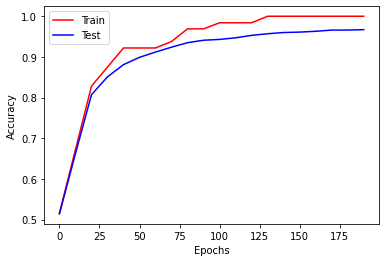

    Epoch  Acc_train  Acc_test  test_loss  train_loss
0     0.0      0.516     0.514      0.711       0.733
1    10.0      0.672     0.662      0.612       0.610
2    20.0      0.828     0.807      0.428       0.432
3    30.0      0.875     0.851      0.365       0.335
4    40.0      0.922     0.881      0.313       0.234
5    50.0      0.922     0.899      0.274       0.183
6    60.0      0.922     0.912      0.244       0.150
7    70.0      0.938     0.924      0.220       0.120
8    80.0      0.969     0.935      0.201       0.096
9    90.0      0.969     0.941      0.187       0.078
10  100.0      0.984     0.943      0.175       0.063
11  110.0      0.984     0.947      0.167       0.051
12  120.0      0.984     0.953      0.160       0.041
13  130.0      1.000     0.957      0.155       0.033
14  140.0      1.000     0.960      0.151       0.026
15  150.0      1.000     0.961      0.147       0.020
16  160.0      1.000     0.963      0.173       0.015
17  170.0      1.000     0.9

In [13]:
plt.plot(Results.Epoch,Results.Acc_train,'r',Results.Epoch,Results.Acc_test,'b')
plt.legend(['Train','Test'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
print(Results)

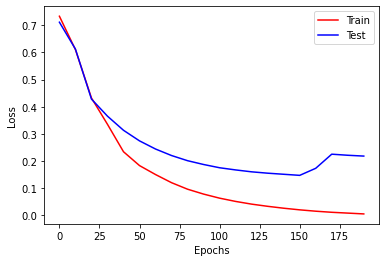

In [14]:
plt.plot(Results.Epoch,Results.train_loss,'r',Results.Epoch,Results.test_loss,'b')
plt.legend(['Train','Test'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [15]:
classes = ['Different Voice', 'Same Voice']
y_pred = CNN(X1_test, X2_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

                 precision    recall  f1-score   support

Different Voice       0.99      0.94      0.97      1495
     Same Voice       0.95      0.99      0.97      1545

       accuracy                           0.97      3040
      macro avg       0.97      0.97      0.97      3040
   weighted avg       0.97      0.97      0.97      3040



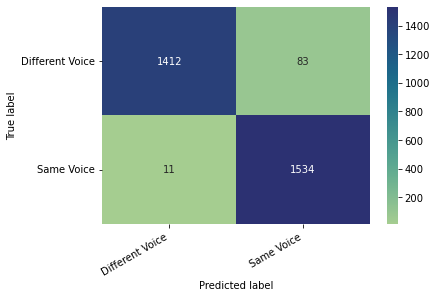

In [16]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
#hmap.color_palette("viridis", as_cmap=True)
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [17]:
y_pred = CNN(X1_val, X2_val)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_val = y_val.cpu()
print(classification_report(y_val, y_pred, target_names=classes))

                 precision    recall  f1-score   support

Different Voice       0.99      0.95      0.97      1233
     Same Voice       0.95      0.99      0.97      1199

       accuracy                           0.97      2432
      macro avg       0.97      0.97      0.97      2432
   weighted avg       0.97      0.97      0.97      2432



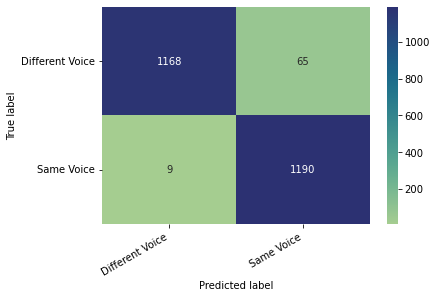

In [18]:
cm = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [19]:
#Shutting down the notebook

%%javascript
Jupyter.notebook.session.delete();

UsageError: Line magic function `%%javascript` not found.
